In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count, prepare_df

In [5]:
from survival_analysis import prepare_df

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000
Using age bins from 0 to 30.0 years with 150 bins

RUNNING 2-CLUSTER ANALYSIS

Initializing 2-cluster analysis with k-means clustering...
Initial cluster assignments:
  G: Cluster 0
  M: Cluster 0
  F: Cluster 1
  J: Cluster 0
  K: Clu

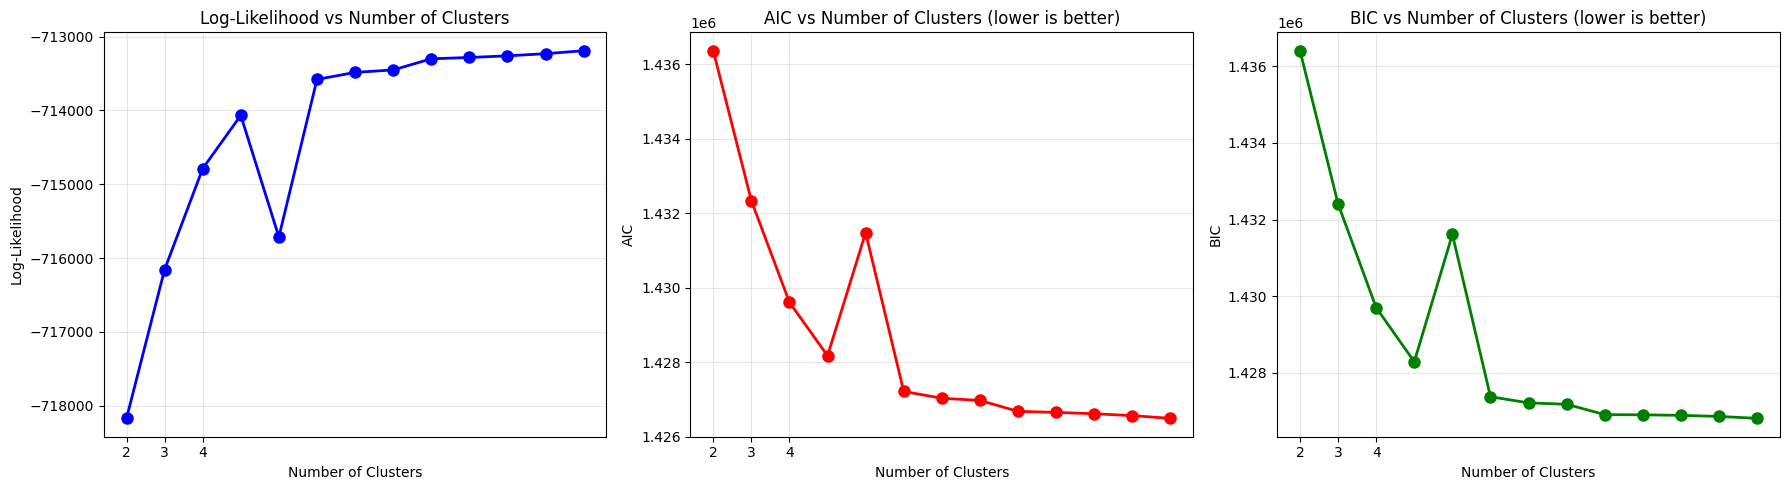

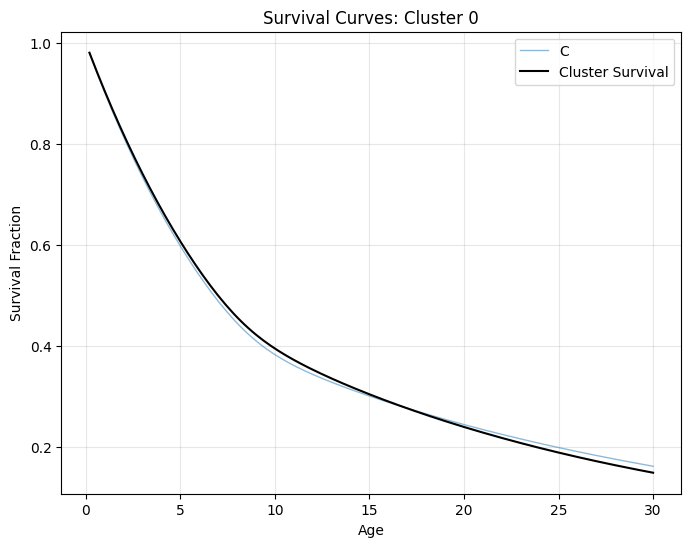

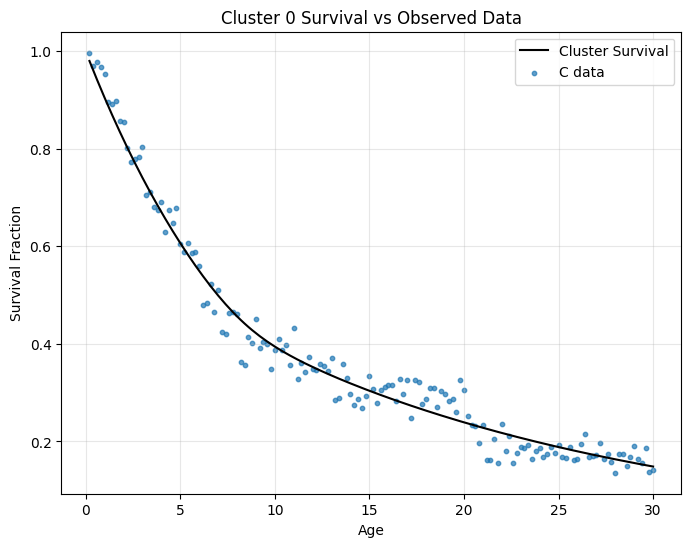

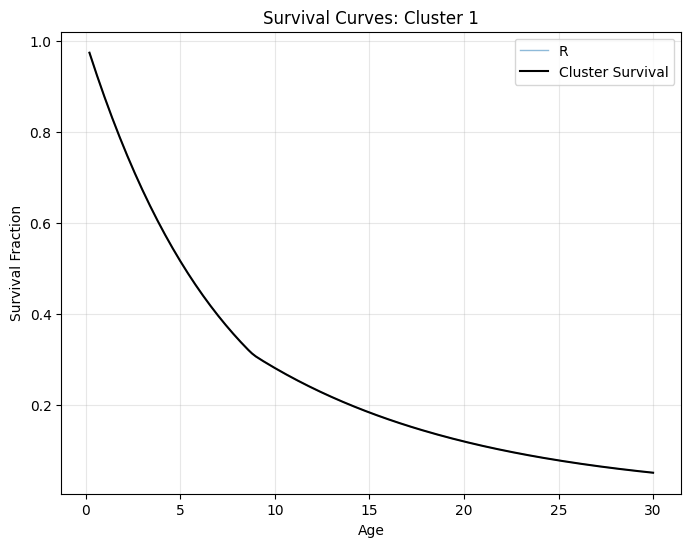

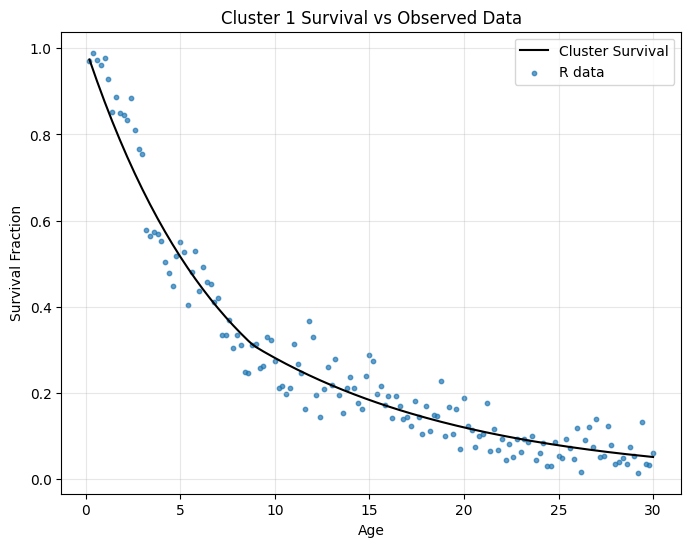

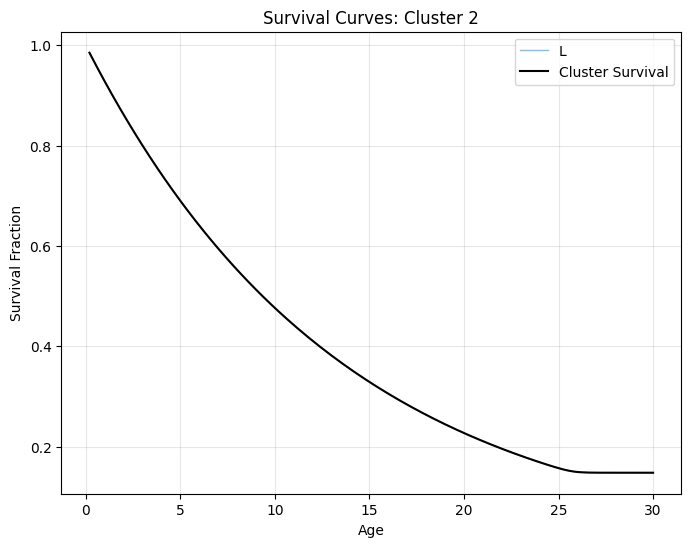

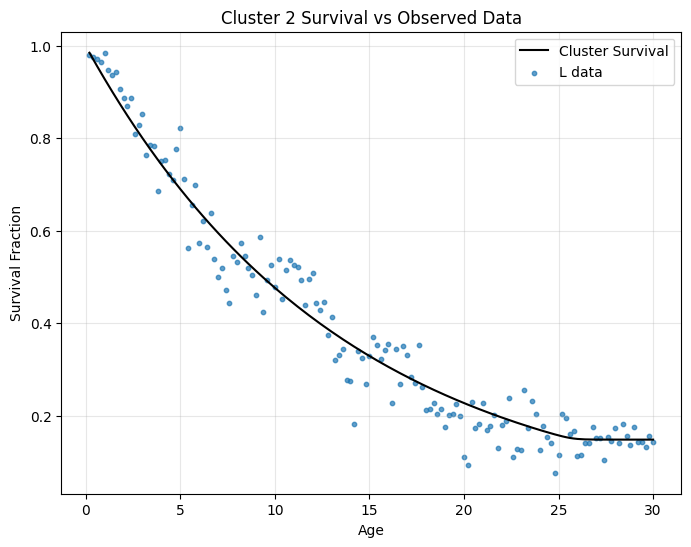

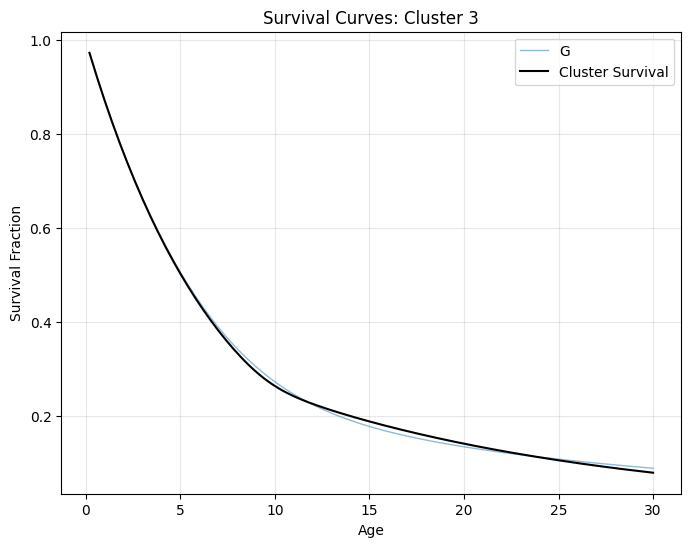

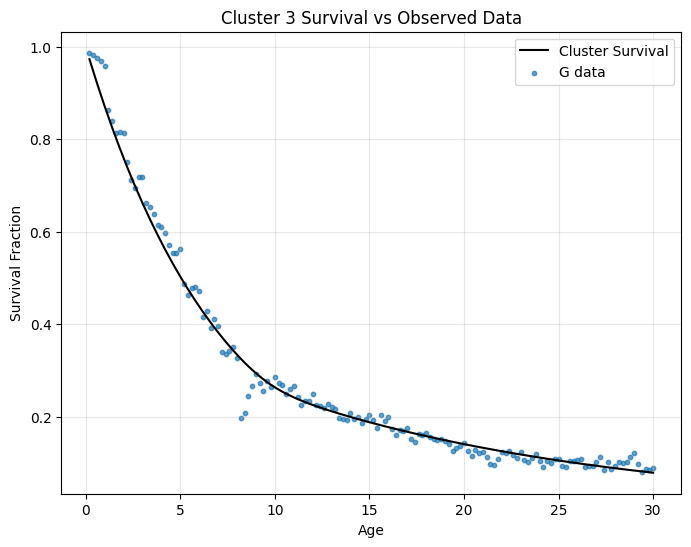

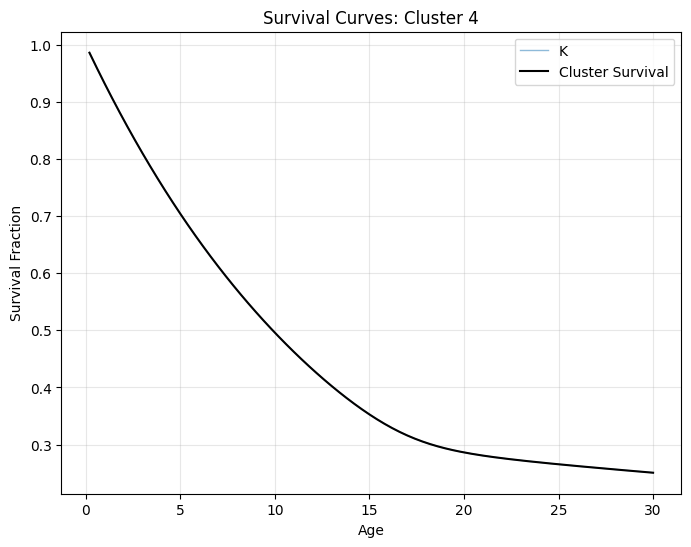

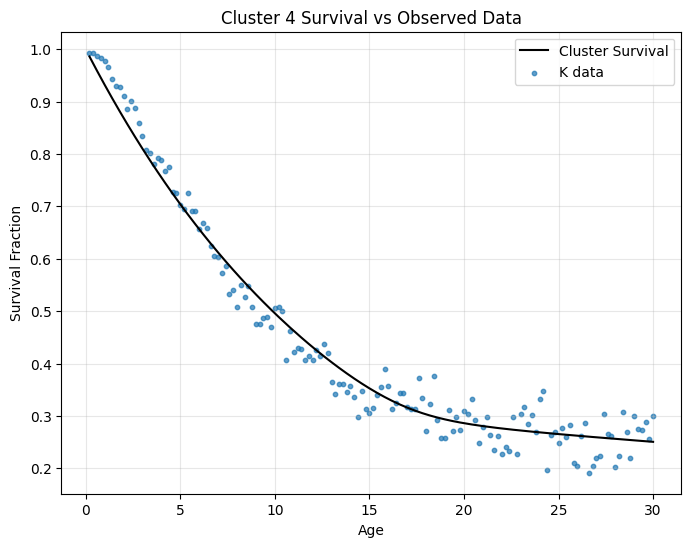

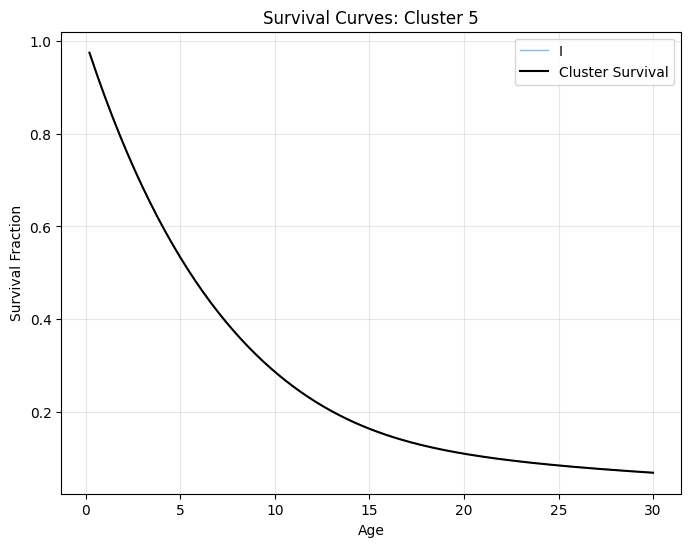

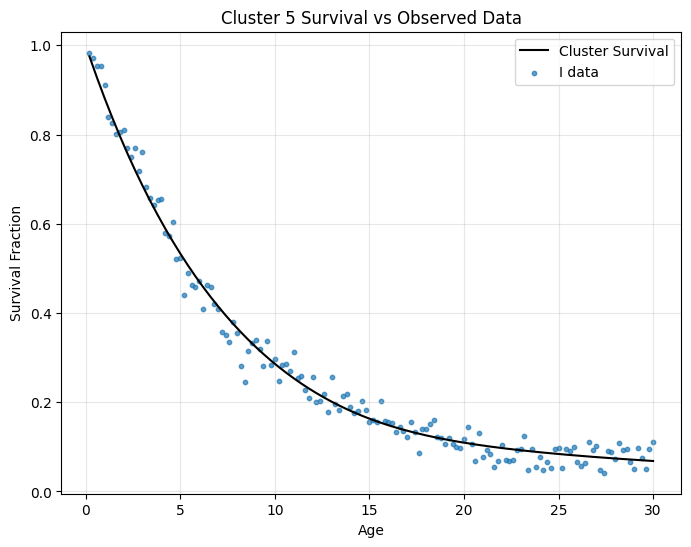

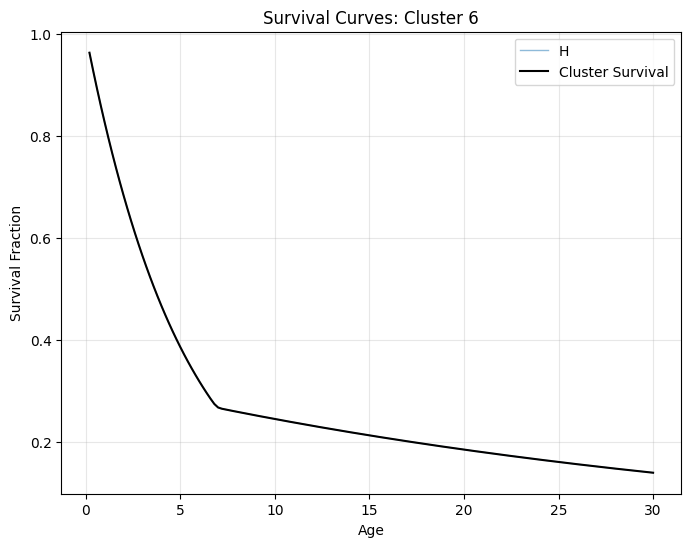

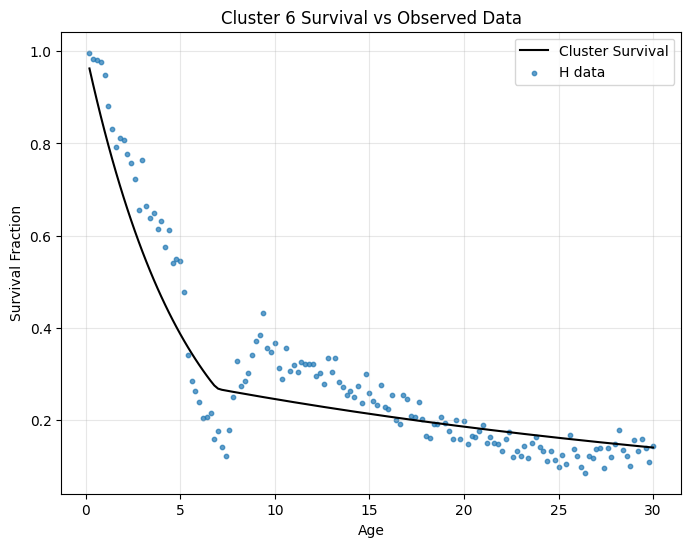

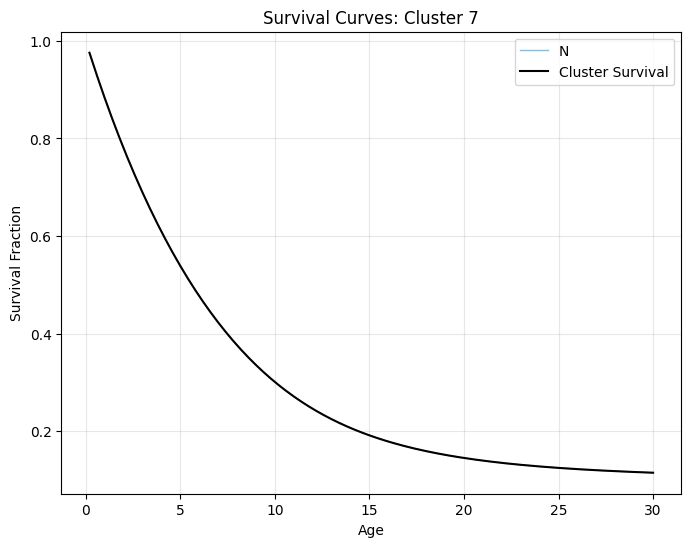

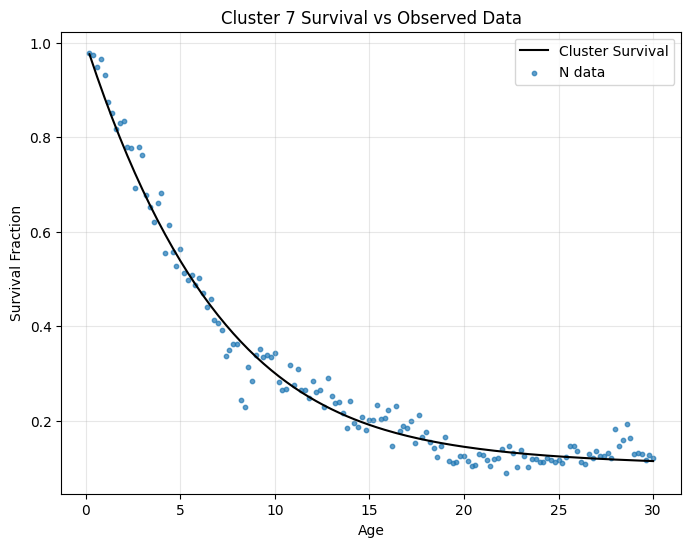

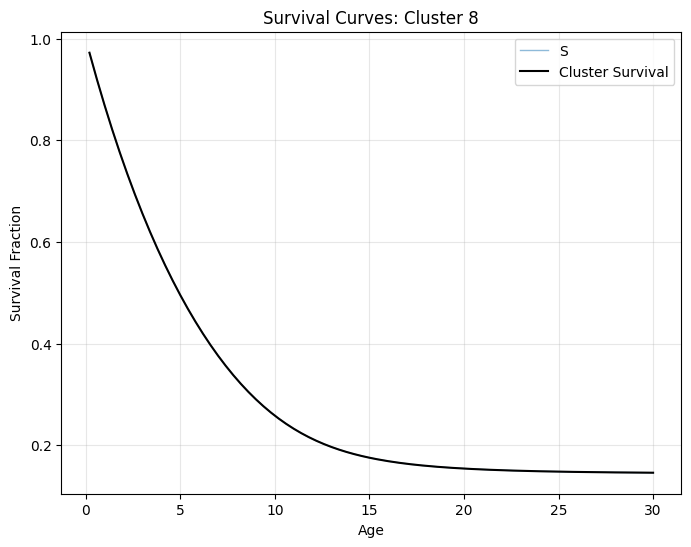

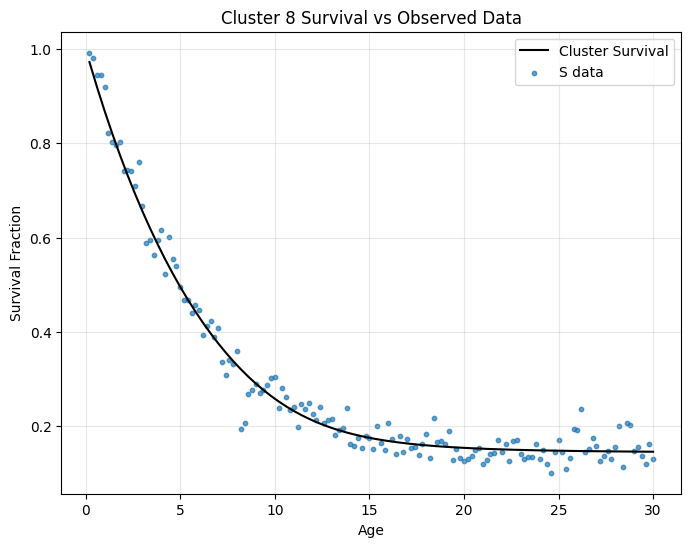

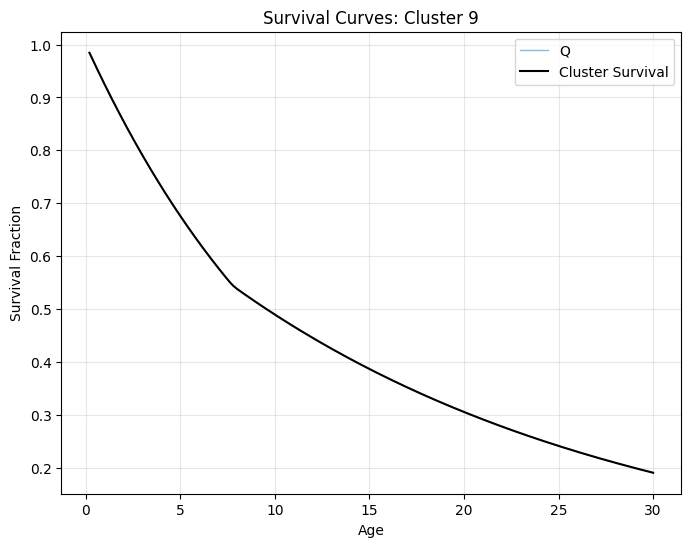

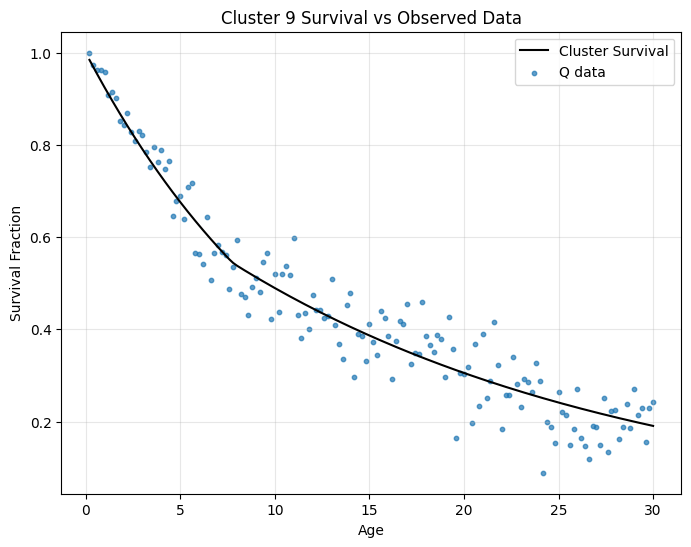

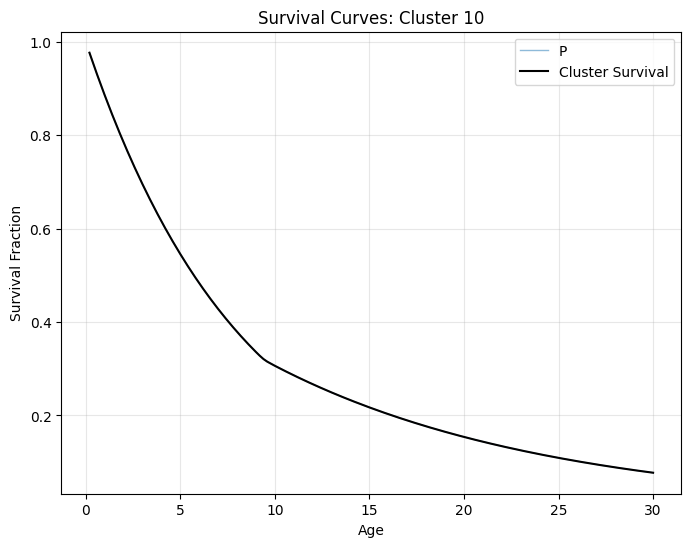

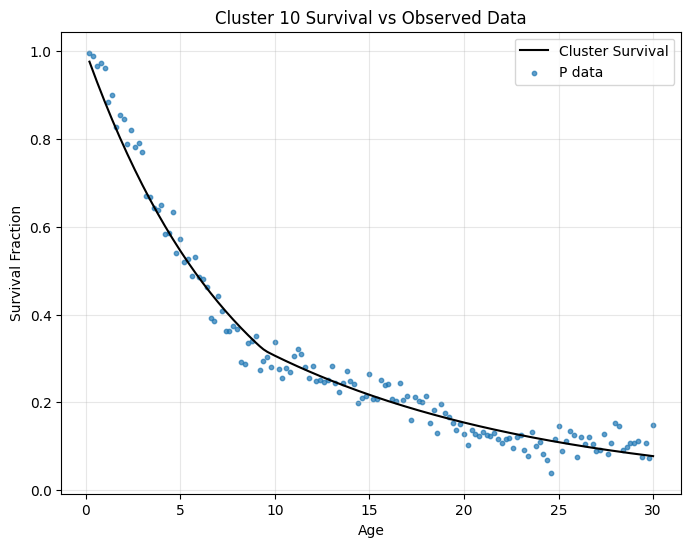

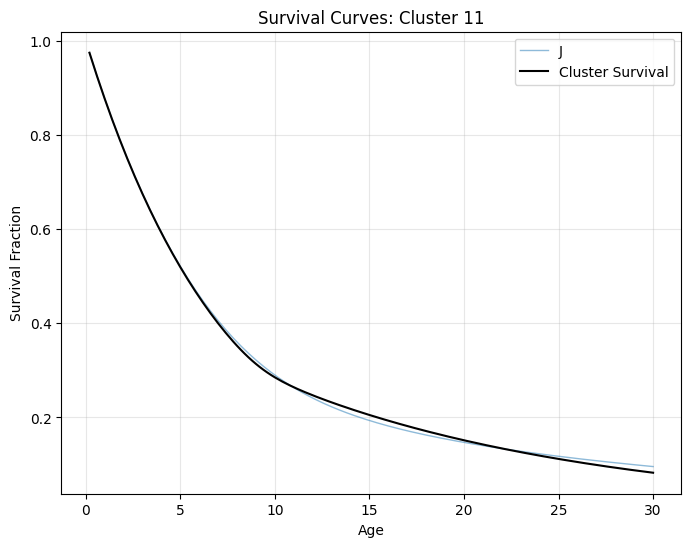

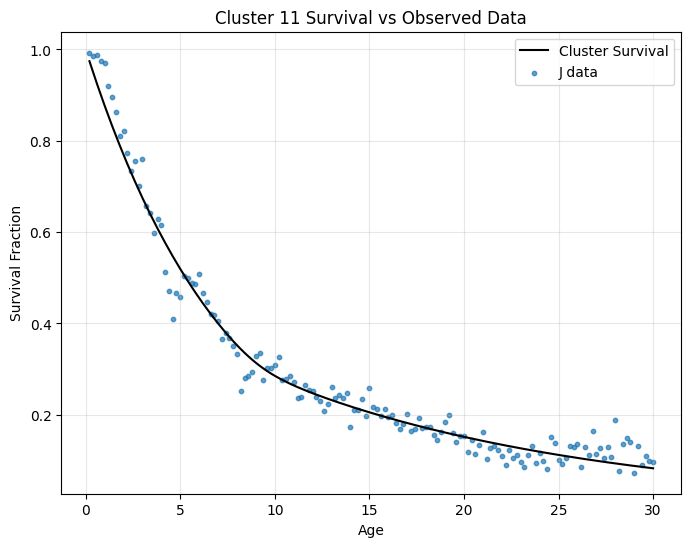

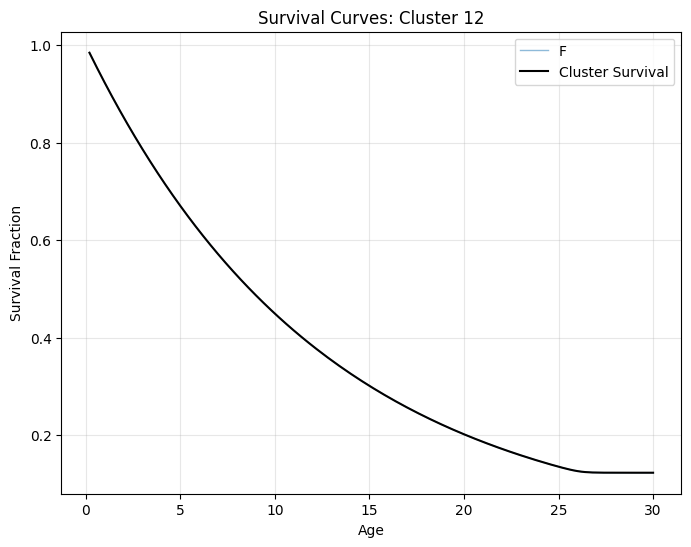

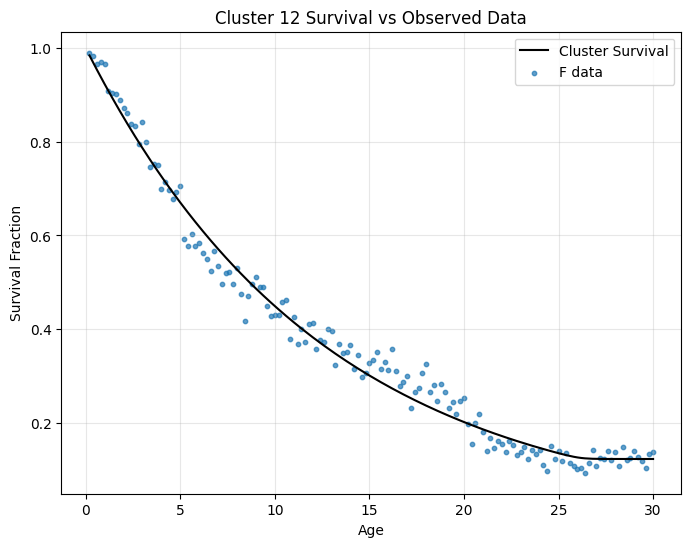

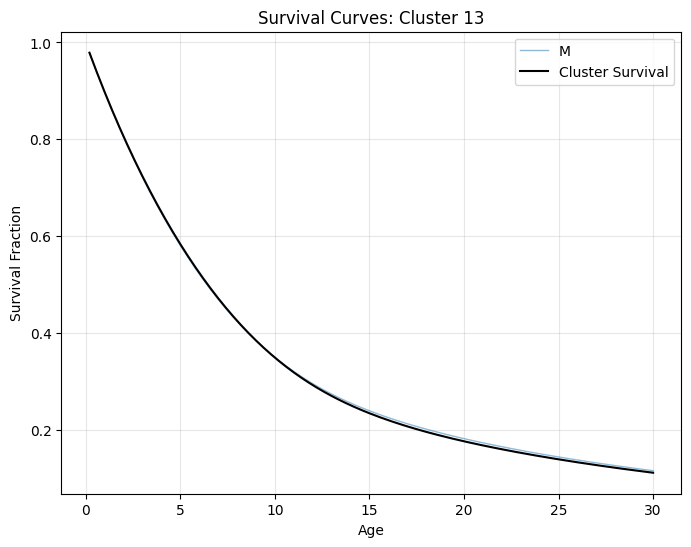

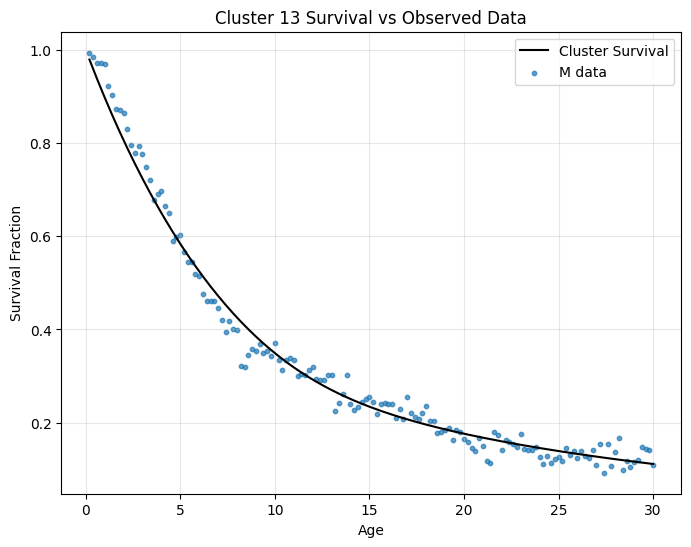

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def reestimate_cluster_params_mle(cluster_sectors):
    """
    Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Define objective function
    def neg_log_likelihood(params):
        ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
        return -ll if np.isfinite(ll) else 1e10
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    
    # Set reasonable bounds with more relaxed m bounds
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0),     # K
              (0.1, 100.0)]     # m
    
    # Optimize
    best_ll = -1e10
    
    # for attempt in range(3):  # Try multiple starting points
    #     try:
    #         if attempt == 0:
    #             start_params = initial_guess
    #         else:
    #             # Add some noise to initial guess for additional attempts
    #             # Use smaller noise for m parameter to avoid extreme values
    #             noise = np.random.normal(0, 0.1, size=4)
    #             noise[3] *= 0.5  # Reduce noise for m parameter
    #             start_params = np.abs(initial_guess + noise * initial_guess)
    #             # Ensure bounds are respected
    #             start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
    #             start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
    #             start_params[2] = np.clip(start_params[2], 0.1, 100.0)
    #             start_params[3] = np.clip(start_params[3], 0.1, 200.0)  # Updated bound
            
    result = minimize(neg_log_likelihood, initial_guess, 
                    method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
        if ll > best_ll:
            best_ll = ll
            best_params = result.x
            
    # except Exception as e:
    #     print(f"    Optimization attempt {attempt+1} failed: {e}")
    #     continue
    
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1, m_tolerance=0.5):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence with weighted parameter changes
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Calculate weighted parameter change - give less weight to m parameter
        param_change = 0
        param_weights = [1.0, 1.0, 1.0, 0.02]  # Less weight on m parameter (index 3)
        
        for cluster_id in range(n_clusters):
            old_params = cluster_params[cluster_id]
            new_params = new_cluster_params[cluster_id]
            
            # Weighted sum of squared differences
            weighted_diff = np.sum([(new_params[i] - old_params[i])**2 * param_weights[i] 
                                  for i in range(4)])
            param_change += weighted_diff/n_clusters
        
        # Also check relative changes for m parameter specifically
        max_m_relative_change = 0
        for cluster_id in range(n_clusters):
            old_m = cluster_params[cluster_id][3]
            new_m = new_cluster_params[cluster_id][3]
            if old_m > 0:
                m_relative_change = abs(new_m - old_m) / old_m
                max_m_relative_change = max(max_m_relative_change, m_relative_change)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Weighted parameter change: {param_change:.6f}")
        print(f"  Max relative m change: {max_m_relative_change:.3f}")
        
        # More tolerant convergence criteria
        m_tolerance = 0.5  # Allow 50% relative change in m parameter
        if (not clusters_changed and 
            param_change < tolerance and 
            max_m_relative_change < m_tolerance):
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 4 parameters per cluster
    n_params = n_clusters * 4
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Run clustering
results = {}
model_comparison = {}

for k in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster parameters:")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: {params[3]:.6f}")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Log-likelihood
axes[0].plot(comparison_df.index, comparison_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of Clusters')
axes[0].grid(True, alpha=0.3)

# AIC
axes[1].plot(comparison_df.index, comparison_df['AIC'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC vs Number of Clusters (lower is better)')
axes[1].grid(True, alpha=0.3)

# BIC
axes[2].plot(comparison_df.index, comparison_df['BIC'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('BIC')
axes[2].set_title('BIC vs Number of Clusters (lower is better)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for cluster_id in range(best_aic):  # Change this to the desired cluster ID to visualize

    # Get sectors in this cluster
    sectors_in_cluster = [sector_list[i] for i, c in enumerate(final_clusters) if c == cluster_id]
    cluster_params = final_params[cluster_id]

    # 1. Plot all individual sector survival curves and the cluster survival curve
    plt.figure(figsize=(8, 6))
    for sector in sectors_in_cluster:
        params = df_params.loc[sector].values
        surv = model_survival_curve_hill(ages_data, *params)
        plt.plot(ages_data, surv, alpha=0.5, label=f"{sector}", linewidth=1)
    # Cluster survival curve
    cluster_surv = model_survival_curve_hill(ages_data, *cluster_params)
    plt.plot(ages_data, cluster_surv, 'k-', label='Cluster Survival')
    plt.xlabel("Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Survival Curves: Cluster {cluster_id}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Plot cluster survival curve with observed data points
    plt.figure(figsize=(8, 6))
    # Cluster survival curve
    plt.plot(ages_data, cluster_surv, 'k-', label='Cluster Survival')
    # Overlay observed data points for all sectors in the cluster
    for sector in sectors_in_cluster:
        obs = survival_data[sector]
        plt.scatter(ages_data, obs, s=10, alpha=0.7, label=f"{sector} data")
    plt.xlabel("Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Cluster {cluster_id} Survival vs Observed Data")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
from scipy.stats import chi2

def likelihood_ratio_test_between_sectors(sector1, sector2):
    # Get data for each sector
    totals1, survivors1 = obtain_total_alive_count(df_analysis, 'Sector', sector1)
    totals2, survivors2 = obtain_total_alive_count(df_analysis, 'Sector', sector2)
    valid1 = totals1 > 0
    valid2 = totals2 > 0
    ages1 = ages_data[:len(survivors1[valid1])]
    ages2 = ages_data[:len(survivors2[valid2])]

    # H1: Fit both sectors together (4 shared parameters)    
    def neg_logL1(params):
        ll1 = log_likelihood(params[:4], ages1, survivors1[valid1], totals1[valid1])
        ll2 = log_likelihood(params[4:], ages2, survivors2[valid2], totals2[valid2])
        return -(ll1 + ll2)
    # Initial guess: concatenate from df_params
    initial_guess = np.concatenate([df_params.loc[sector1].values, df_params.loc[sector2].values])
    bounds = [(1e-6, 1.0), (1e-10, 1.0), (0.1, 100.0), (0.1, 100.0)] * 2
    res1 = minimize(neg_logL1, initial_guess, bounds=bounds, method='L-BFGS-B')
    ll1 = -res1.fun

    # H0: Fit each sector separately (8 parameters: 4 per sector)
    combined_ages = np.concatenate([ages1, ages2])
    combined_survivors = np.concatenate([survivors1[valid1], survivors2[valid2]])
    combined_totals = np.concatenate([totals1[valid1], totals2[valid2]])
    def neg_logL2(params):
        return -log_likelihood(params, combined_ages, combined_survivors, combined_totals)
    initial_guess2 = np.mean([df_params.loc[sector1].values, df_params.loc[sector2].values], axis=0)
    bounds2 = [(1e-6, 1.0), (1e-10, 1.0), (0.1, 100.0), (0.1, 100.0)]
    res2 = minimize(neg_logL2, initial_guess2, bounds=bounds2, method='L-BFGS-B')
    ll2 = -res2.fun

    # Likelihood ratio statistic
    LR = 2 * (ll2 - ll1)
    df = 4  # difference in number of parameters
    p_value = chi2.sf(LR, df)

    # print(f"Sector1: {sector1}, Sector2: {sector2}")
    # print(f"  LogL (separate): {ll1:.2f}")
    # print(f"  LogL (shared):   {ll2:.2f}")
    # print(f"  LR statistic:    {LR:.2f}")
    # print(f"  p-value:         {p_value:.4g}")

    return {
        'sector1': sector1,
        'sector2': sector2,
        'logL_separate': ll1,
        'logL_shared': ll2,
        'LR_stat': LR,
        'df': df,
        'p_value': p_value,
        'params_separate': res1.x,
        'params_shared': res2.x
    }

for sector in sector_list:
    for sector2 in sector_list:
        if sector == sector2:
            continue
        if likelihood_ratio_test_between_sectors(sector, sector2)['p_value'] < 0.05:
            print(f"Significant difference between {sector} and {sector2} (p < 0.05)")

# Only G and R

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Significant difference between G and R (p < 0.05)


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in

Significant difference between R and G (p < 0.05)


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

# Hill function with fixed m=5 - IMPROVED VERSION
def hill3k_hazard(a, mu_ub, mu_lb, K):
    """
    Improved Hill hazard function with better numerical stability
    """
    # Add small epsilon to avoid exactly zero age
    a = max(a, 1e-8)
    
    # Compute a^5 and K^5
    a5 = a**5
    K5 = K**5
    
    # Avoid division by zero and numerical overflow
    denominator = a5 + K5 + 1e-10
    
    # Compute hazard with bounds checking
    hazard = mu_ub - (mu_ub - mu_lb) * a5 / denominator
    
    # Ensure hazard is non-negative and finite
    hazard = max(0, min(hazard, 10.0))  # Cap hazard at reasonable value
    
    return hazard

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    """
    Improved survival function with better integration handling
    """
    if a <= 0:
        return 1.0
    
    try:
        # Use more robust integration with better error handling
        result, error = quad(
            lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 
            0, a,
            limit=100,          # Increase subdivision limit
            epsabs=1e-8,        # Absolute error tolerance
            epsrel=1e-6         # Relative error tolerance
        )
        
        # Check for integration issues
        if not np.isfinite(result):
            print(f"Warning: Non-finite integral result for a={a}, params=({mu_ub}, {mu_lb}, {K})")
            result = 10.0  # Use large value to give survival ≈ 0
            
        # Prevent numerical overflow in exp
        result = min(result, 50.0)  # Cap to prevent exp overflow
        
        survival = np.exp(-result)
        return max(1e-12, min(1.0, survival))  # Ensure valid probability
        
    except Exception as e:
        print(f"Integration failed for a={a}, params=({mu_ub}, {mu_lb}, {K}): {e}")
        # Return reasonable fallback based on age
        return max(1e-12, np.exp(-a * mu_ub))

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    """
    Vectorized survival curve with error handling
    """
    # Check parameter validity
    if mu_ub <= 0 or mu_lb < 0 or K <= 0 or mu_ub < mu_lb:
        print(f"Warning: Invalid parameters - mu_ub={mu_ub}, mu_lb={mu_lb}, K={K}")
        # Return exponential decay as fallback
        return np.exp(-np.array(ages) * max(mu_ub, 0.01))
    
    survival_values = []
    for a in ages:
        try:
            s_val = hill3k_survival_function(a, mu_ub, mu_lb, K)
            survival_values.append(s_val)
        except Exception as e:
            print(f"Error computing survival at age {a}: {e}")
            survival_values.append(np.exp(-a * mu_ub))  # Fallback
    
    return np.array(survival_values)

# Enhanced debugging version with more granular error reporting
# def debug_hill_function(mu_ub, mu_lb, K, max_age=30):
#     """
#     Debug function to test Hill function behavior with detailed error reporting
#     """
#     print(f"\nDebugging Hill function with params: mu_ub={mu_ub:.6f}, mu_lb={mu_lb:.6f}, K={K:.6f}")
    
#     # Check parameter validity first
#     if mu_lb < 0:
#         print(f"  ERROR: mu_lb is negative ({mu_lb})")
#         return False
#     if mu_ub <= mu_lb:
#         print(f"  ERROR: mu_ub ({mu_ub}) <= mu_lb ({mu_lb})")
#         return False
#     if K <= 0:
#         print(f"  ERROR: K is non-positive ({K})")
#         return False
    
#     print("  Parameters appear valid, testing function evaluations...")
    
#     # Test hazard at different ages
#     test_ages = [0.1, 1, 5, 10, 20, 30]
#     print("  Hazard values:")
#     hazard_success = True
#     for age in test_ages:
#         try:
#             hazard = hill3k_hazard(age, mu_ub, mu_lb, K)
#             if not np.isfinite(hazard):
#                 print(f"    Age {age:4.1f}: {hazard:.6f} (NON-FINITE!)")
#                 hazard_success = False
#             else:
#                 print(f"    Age {age:4.1f}: {hazard:.6f}")
#         except Exception as e:
#             print(f"    Age {age:4.1f}: ERROR - {e}")
#             hazard_success = False
    
#     # Test survival at different ages
#     print("  Survival values:")
#     survival_success = True
#     for age in test_ages:
#         try:
#             survival = hill3k_survival_function(age, mu_ub, mu_lb, K)
#             if not np.isfinite(survival) or survival < 0 or survival > 1:
#                 print(f"    Age {age:4.1f}: {survival:.6f} (INVALID!)")
#                 survival_success = False
#             else:
#                 print(f"    Age {age:4.1f}: {survival:.6f}")
#         except Exception as e:
#             print(f"    Age {age:4.1f}: ERROR - {e}")
#             survival_success = False
    
#     overall_success = hazard_success and survival_success
#     print(f"  Overall success: {overall_success}")
#     return overall_success

# Legacy functions for backward compatibility (redirect to 3k versions)
def hill_hazard(a, mu_ub, mu_lb, K, m=5):
    return hill3k_hazard(a, mu_ub, mu_lb, K)

def hill_survival_function(a, mu_ub, mu_lb, K, m=5):
    return hill3k_survival_function(a, mu_ub, mu_lb, K)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m=5):
    return model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params  # Only 3 parameters now
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    return -log_likelihood(params, ages, survivors, totals)

def reestimate_cluster_params_mle(cluster_sectors):
    """
    CORRECTED: Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    print(f"    Re-estimating parameters for sectors: {cluster_sectors}")
    
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    print(f"    Initial guess: mu_ub={initial_guess[0]:.4f}, mu_lb={initial_guess[1]:.4f}, K={initial_guess[2]:.4f}")
    
    # # Debug the initial parameters
    # try:
    #     debug_hill_function(initial_guess[0], initial_guess[1], initial_guess[2])
    # except:
    #     print("    Debug function failed, continuing with optimization...")
    
    # Define objective function with better error handling
    def neg_log_likelihood(params):
        try:
            ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
            if not np.isfinite(ll):
                return 1e10
            return -ll
        except Exception as e:
            print(f"    Likelihood computation failed: {e}")
            return 1e10
    
    # Set reasonable bounds for 3 parameters
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0)]     # K
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts (3 parameters)
                noise = np.random.normal(0, 0.05, size=3)  # Reduced noise
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
            
            # print(f"    Attempt {attempt+1}: Starting with {start_params}")
            
            result = minimize(neg_log_likelihood, start_params, 
                            method='L-BFGS-B', bounds=bounds,
                            options={'maxiter': 100})
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                # print(f"    Attempt {attempt+1}: Success, LL={ll:.2f}")
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
            else:
                print(f"    Attempt {attempt+1}: Failed - {result.message}")
                    
        except Exception as e:
            print(f"    Optimization attempt {attempt+1} failed: {e}")
            continue
    
    print(f"    Final parameters: mu_ub={best_params[0]:.4f}, mu_lb={best_params[1]:.4f}, K={best_params[2]:.4f}")
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    print("K-means clustering works by:")
    print("  1. Randomly placing k cluster centers in the parameter space")
    print("  2. Assigning each sector to the nearest cluster center (Euclidean distance)")
    print("  3. Moving cluster centers to the mean of assigned sectors")
    print("  4. Repeating steps 2-3 until convergence")
    print("  This provides good initial cluster assignments based on parameter similarity")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters (m=5 fixed):")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters (m=5 fixed):")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
        
        # Check convergence - simplified for 3 parameters
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Standard parameter change calculation
        param_change = 0
        for cluster_id in range(n_clusters):
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 3 parameters per cluster (m fixed at 5)
    n_params = n_clusters * 3
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# COMPREHENSIVE PARAMETER VALIDATION
print("\n" + "="*60)
print("COMPREHENSIVE PARAMETER VALIDATION")
print("="*60)

# # Check all individual sector parameters
# print("Validating individual sector parameters:")
# valid_sectors = []
# invalid_sectors = []

# for sector in sector_list:
#     params = df_params.loc[sector].values
#     print(f"\nSector {sector}: {params}")
    
#     try:
#         is_valid = debug_hill_function(params[0], params[1], params[2])
#         if is_valid:
#             valid_sectors.append(sector)
#             print(f"  ✓ {sector} parameters are valid")
#         else:
#             invalid_sectors.append(sector)
#             print(f"  ✗ {sector} parameters have issues")
#     except Exception as e:
#         invalid_sectors.append(sector)
#         print(f"  ✗ {sector} debug failed: {e}")

# print(f"\nValidation Summary:")
# print(f"  Valid sectors ({len(valid_sectors)}): {valid_sectors}")
# print(f"  Invalid sectors ({len(invalid_sectors)}): {invalid_sectors}")

# if invalid_sectors:
#     print(f"\n⚠️  WARNING: {len(invalid_sectors)} sectors have parameter issues!")
#     print("  Consider:")
#     print("  1. Checking original parameter estimation")
#     print("  2. Using more conservative parameter bounds")
#     print("  3. Excluding problematic sectors from clustering")
    
#     # Option to continue or fix
#     print(f"\n  Proceeding with clustering anyway...")
# else:
#     print(f"\n✓ All sector parameters passed validation!")

print("\n" + "="*60)
print("STARTING CLUSTERING ANALYSIS")
print("="*60)
results = {}
model_comparison = {}

for k in [3, 4, 5]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters (m=5 fixed):")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: 5.0 (fixed)")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Visualization code remains the same...
# [Rest of plotting code would go here]

Individual Sector Parameters:
      mu_ub         mu_lb          K
G  0.136600  3.574423e-02  12.391134
M  0.108775  4.180960e-02  12.552693
F  0.079990  1.000000e-10  26.182377
J  0.130908  3.791174e-02  11.942981
K  0.070120  1.107103e-02  17.600632
C  0.103010  4.128293e-02   9.260455
H  0.190144  2.801602e-02   6.937676
S  0.140580  1.000000e-10  12.953553
N  0.123962  1.000000e-10  16.432767
I  0.125687  3.447114e-02  17.442831
P  0.121214  6.868425e-02   9.445186
L  0.074121  1.000000e-10  25.775318
Q  0.078302  4.719794e-02   7.791976
R  0.132290  8.548577e-02   8.857323
Using age bins from 0 to 30.0 years with 150 bins

COMPREHENSIVE PARAMETER VALIDATION

STARTING CLUSTERING ANALYSIS

RUNNING 3-CLUSTER ANALYSIS

Initializing 3-cluster analysis with k-means clustering...
K-means clustering works by:
  1. Randomly placing k cluster centers in the parameter space
  2. Assigning each sector to the nearest cluster center (Euclidean distance)
  3. Moving cluster centers to the mean o

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5523
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7311
Updated cluster parameters (m=5 fixed):
  Cluster 0 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5523
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7311
  Clusters changed: True
  Parameter change: 171.241946

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-198418.30, LL_1=-201962.06, LL_2=-217863.54 → Cluster 0
  M: LL_0=-108772.93, LL_1=-106907.52, LL_2=-110303.04 → Cluster 1
  F: LL_0=-50751.57, LL_1=-48615.43, LL_2=-48022.45 → Cluster 2
  J: LL_0=-57047.42, LL_1=-57589.44, LL_2=-61426.65 → Cluster 0
  K: LL_0=-64297.81, LL_1=-59749.75, LL_2=-56673.36 → Cluster 2
  C: LL_0=-41529.66, LL_1=-40078.37, LL_2=-39810.21 → Cluster 2
  H: LL_0=-44396.17, LL_1=-46

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1422
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7325
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 1 (2 sectors): mu_ub=0.1106, mu_lb=0.0491, K=12.1422
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7325
  Clusters changed: True
  Parameter change: 0.168843

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-198421.87, LL_1=-201292.05, LL_2=-217863.30 → Cluster 0
  M: LL_0=-108899.21, LL_1=-106925.37, LL_2=-110302.96 → Cluster 1
  F: LL_0=-50844.12, LL_1=-48754.17, LL_2=-48022.45 → Cluster 2
  J: LL_0=-57065.28, LL_1=-57451.30, LL_2=-61426.59 → Cluster 0
  K: LL_0=-64473.72, LL_1=-60123.96, LL_2=-56673.36 → Cluster 2
  C: LL_0=-41581.68, LL_1=-40199.64, LL_2=-39810.20 → Cluster 2
  H: LL_0=-44347.86, LL_1=-46205.74, LL_2=-51345.10 → Cluster 0
  S: LL_0=-35840.72, LL_1=-36366.45, LL_2=-39297.34 → Cluster 0
  N: LL_0=-37127.56, LL_1=-37222.61, LL_2=-39615.15 → Cluster 0
  I: LL_0=-34403.50, LL_

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1420
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 1 (2 sectors): mu_ub=0.1106, mu_lb=0.0491, K=12.1420
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Clusters changed: False
  Parameter change: 0.000016

--- Iteration 4 ---
Likelihood-based assignments:
  G: LL_0=-198421.87, LL_1=-201292.00, LL_2=-217863.28 → Cluster 0
  M: LL_0=-108899.21, LL_1=-106925.37, LL_2=-110302.95 → Cluster 1
  F: LL_0=-50844.12, LL_1=-48754.17, LL_2=-48022.44 → Cluster 2
  J: LL_0=-57065.28, LL_1=-57451.30, LL_2=-61426.54 → Cluster 0
  K: LL_0=-64473.71, LL_1=-60123.99, LL_2=-56673.38 → Cluster 2
  C: LL_0=-41581.68, LL_1=-40199.66, LL_2=-39810.19 → Cluster 2
  H: LL_0=-44347.85, LL_1=-462

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1421
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7327
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 1 (2 sectors): mu_ub=0.1106, mu_lb=0.0491, K=12.1421
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7327
  Clusters changed: False
  Parameter change: 0.000017

--- Iteration 5 ---
Likelihood-based assignments:
  G: LL_0=-198421.87, LL_1=-201292.01, LL_2=-217863.31 → Cluster 0
  M: LL_0=-108899.22, LL_1=-106925.37, LL_2=-110302.97 → Cluster 1
  F: LL_0=-50844.12, LL_1=-48754.17, LL_2=-48022.45 → Cluster 2
  J: LL_0=-57065.28, LL_1=-57451.30, LL_2=-61426.60 → Cluster 0
  K: LL_0=-64473.72, LL_1=-60123.99, LL_2=-56673.36 → Cluster 2
  C: LL_0=-41581.68, LL_1=-40199.67, LL_2=-39810.20 → Cluster 2
  H: LL_0=-44347.85, LL_1=-462

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1420
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7332
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 1 (2 sectors): mu_ub=0.1106, mu_lb=0.0491, K=12.1420
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7332
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

3-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -716364.73
AIC: 1432747.46
BIC: 1432798.31

Final cluster assignments:
  G: Cluster 0
  M: Cluster 1
  F: Cluster 2
  J: Cluster 0
  K: Cluster 2
  C: Cluster 2
  H: Cluster 0
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 1
  L: Cluster 2
  Q: Cluster 2
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (7 sectors): ['G', 'J', 'H', 'S', 'N', 'I', 'R']
  mu_ub: 0.141197
  mu_lb: 0

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5522
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'N', 'I', 'P', 'R']
    Initial guess: mu_ub=0.1377, mu_lb=0.0363, K=12.0504


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1250, mu_lb=0.0541, K=8.4585
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5522
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Clusters changed: True
  Parameter change: 176.739043

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-200548.91, LL_1=-201962.03, LL_2=-217863.28, LL_3=-198418.30 → Cluster 3
  M: LL_0=-107228.27, LL_1=-106907.52, LL_2=-110302.95, LL_3=-108772.93 → Cluster 1
  F: LL_0=-49066.10, LL_1=-48615.43, LL_2=-48022.44, LL_3=-50751.57 → Cluster 2
  J: LL_0=-57213.99, LL_1=-57589.43, LL_2=-61426.54, LL_3=-57047.42 → Cluster 3
  K: LL_0=-60993.18, LL_1=-59749.77, LL_2=-56673.38, LL_3=-64297.81 → Cluster 2
  C: LL_0=-40251.92, LL_1=-40078.37, LL_2=-39810.19, LL_3=-41529.66 → Cluster 2
  H: LL_0=-45180.85, LL_1=-46445.03, LL_2=-51344.93, L

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1213, mu_lb=0.0599, K=10.6700
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5531
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7298
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'N', 'I', 'R']
    Initial guess: mu_ub=0.1400, mu_lb=0.0317, K=12.4226


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1213, mu_lb=0.0599, K=10.6700
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5531
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7298
  Cluster 3 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Clusters changed: True
  Parameter change: 4.891331

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-199302.36, LL_1=-201961.94, LL_2=-217863.25, LL_3=-198421.87 → Cluster 3
  M: LL_0=-107386.51, LL_1=-106907.52, LL_2=-110302.94, LL_3=-108899.21 → Cluster 1
  F: LL_0=-49528.00, LL_1=-48615.48, LL_2=-48022.45, LL_3=-50844.12 → Cluster 2
  J: LL_0=-57082.49, LL_1=-57589.41, LL_2=-61426.54, LL_3=-57065.28 → Cluster 3
  K: LL_0=-61893.52, LL_1=-59749.80, LL_2=-56673.38, LL_3=-64473.72 → Cluster 2
  C: LL_0=-40882.18, LL_1=-40078.38, LL_2=-39810.19, LL_3=-41581.68 → Cluster 2
  H: LL_0=-45399.87, LL_1=-46445.04, LL_2=-51344.96, LL

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1223, mu_lb=0.0386, K=13.0378
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5525
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7320
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'I', 'R']
    Initial guess: mu_ub=0.1427, mu_lb=0.0369, K=11.7542


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1426, mu_lb=0.0473, K=9.9867
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.1223, mu_lb=0.0386, K=13.0378
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5525
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7320
  Cluster 3 (6 sectors): mu_ub=0.1426, mu_lb=0.0473, K=9.9867
  Clusters changed: True
  Parameter change: 5.620246

--- Iteration 4 ---
Likelihood-based assignments:
  G: LL_0=-199057.88, LL_1=-201962.12, LL_2=-217863.26, LL_3=-198430.33 → Cluster 3
  M: LL_0=-107527.21, LL_1=-106907.52, LL_2=-110302.95, LL_3=-109039.65 → Cluster 1
  F: LL_0=-49736.55, LL_1=-48615.43, LL_2=-48022.45, LL_3=-50945.44 → Cluster 2
  J: LL_0=-57045.56, LL_1=-57589.44, LL_2=-61426.58, LL_3=-57086.90 → Cluster 0
  K: LL_0=-62132.19, LL_1=-59749.72, LL_2=-56673.36, LL_3=-64675.37 → Cluster 2
  C: LL_0=-40886.30, LL_1=-40078.35, LL_2=-39810.20, LL_3=-41653.66 → Cluster 2
  H: LL_0=-45304.91, LL_1=-46445.06, LL_2=-51345.07, LL_3

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1452, mu_lb=0.0470, K=9.7829
Updated cluster parameters (m=5 fixed):
  Cluster 0 (3 sectors): mu_ub=0.1272, mu_lb=0.0464, K=11.3903
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5515
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7333
  Cluster 3 (5 sectors): mu_ub=0.1452, mu_lb=0.0470, K=9.7829
  Clusters changed: True
  Parameter change: 2.755784

--- Iteration 5 ---
Likelihood-based assignments:
  G: LL_0=-198785.17, LL_1=-201962.00, LL_2=-217863.31, LL_3=-198475.20 → Cluster 3
  M: LL_0=-107753.30, LL_1=-106907.52, LL_2=-110302.97, LL_3=-109280.19 → Cluster 1
  F: LL_0=-49931.39, LL_1=-48615.42, LL_2=-48022.45, LL_3=-51105.44 → Cluster 2
  J: LL_0=-57001.06, LL_1=-57589.42, LL_2=-61426.61, LL_3=-57130.46 → Cluster 0
  K: LL_0=-62624.01, LL_1=-59749.79, LL_2=-56673.35, LL_3=-64995.87 → Cluster 2
  C: LL_0=-41003.45, LL_1=-40078.38, LL_2=-39810.20, LL_3=-41748.25 → Cluster 2
  H: LL_0=-44989.46, LL_1=-46445.00, LL_2=-51345.14, LL_3

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1270, mu_lb=0.0481, K=12.0917
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5515
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'H', 'S', 'R']
    Initial guess: mu_ub=0.1499, mu_lb=0.0373, K=10.2849


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1477, mu_lb=0.0455, K=9.4998
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.1270, mu_lb=0.0481, K=12.0917
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5515
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (4 sectors): mu_ub=0.1477, mu_lb=0.0455, K=9.4998
  Clusters changed: True
  Parameter change: 0.572047

--- Iteration 6 ---
Likelihood-based assignments:
  G: LL_0=-198622.72, LL_1=-201962.01, LL_2=-217863.28, LL_3=-198560.74 → Cluster 3
  M: LL_0=-107945.51, LL_1=-106907.52, LL_2=-110302.95, LL_3=-109411.94 → Cluster 1
  F: LL_0=-50158.51, LL_1=-48615.42, LL_2=-48022.44, LL_3=-51154.59 → Cluster 2
  J: LL_0=-57005.30, LL_1=-57589.42, LL_2=-61426.54, LL_3=-57166.41 → Cluster 0
  K: LL_0=-63026.88, LL_1=-59749.79, LL_2=-56673.38, LL_3=-65119.57 → Cluster 2
  C: LL_0=-41282.04, LL_1=-40078.37, LL_2=-39810.19, LL_3=-41722.61 → Cluster 2
  H: LL_0=-45063.13, LL_1=-46444.99, LL_2=-51344.93, LL_3

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8267
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5517
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7322
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4924
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8267
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5517
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7322
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4924
  Clusters changed: True
  Parameter change: 0.070304

--- Iteration 7 ---
Likelihood-based assignments:
  G: LL_0=-198606.07, LL_1=-201961.99, LL_2=-217863.23, LL_3=-198582.11 → Cluster 3
  M: LL_0=-107986.34, LL_1=-106907.52, LL_2=-110302.94, LL_3=-109439.03 → Cluster 1
  F: LL_0=-50197.42, LL_1=-48615.43, LL_2=-48022.45, LL_3=-51165.81 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.42, LL_2=-61426.57, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.54, LL_1=-59749.79, LL_2=-56673.36, LL_3=-65140.28 → Cluster 2
  C: LL_0=-41340.51, LL_1=-40078.38, LL_2=-39810.20, LL_3=-41712.89 → Cluster 2
  H: LL_0=-45054.25, LL_1=-46445.00, LL_2=-51345.06, LL_3

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8268
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5515
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4924
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8268
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5515
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4924
  Clusters changed: False
  Parameter change: 0.000014

--- Iteration 8 ---
Likelihood-based assignments:
  G: LL_0=-198606.0

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5519
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5519
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

4-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -715991.16
AIC: 1432006.31
BIC: 1432074.11

Final cluster assignments:
  G: Cluster 3
  M: Cluster 1
  F: Cluster 2
  J: Cluster 0
  K: Cluster 2
  C: Cluster 2
  H: Cluster 3
  S: Cluster 3
  N: Cluster 0
  I: Cluster 0
  P: Cluster 0
  L: Cluster 2
  Q: Cluster 2
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
  mu_ub: 0.127360
  mu_lb: 0.051202
  K: 11.826905
  m: 5.0 (fixed)

Cluster 1 (1 sectors): ['M']
  mu_ub: 0.108154
  mu_lb: 0.046532
  K: 12.551949
  m: 5.0 (fix

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1213, mu_lb=0.0599, K=10.6699
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5519
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7320
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'N', 'I', 'R']
    Initial guess: mu_ub=0.1400, mu_lb=0.0317, K=12.4226


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1213, mu_lb=0.0599, K=10.6699
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5519
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7320
  Cluster 3 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 4 (0 sectors): mu_ub=0.1342, mu_lb=0.0376, K=7.3648
  Clusters changed: True
  Parameter change: 178.969267

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-199302.34, LL_1=-201962.02, LL_2=-217863.27, LL_3=-198421.87, LL_4=-203859.88 → Cluster 3
  M: LL_0=-107386.52, LL_1=-106907.52, LL_2=-110302.95, LL_3=-108899.21, LL_4=-107883.10 → Cluster 1
  F: LL_0=-49528.01, LL_1=-48615.43, LL_2=-48022.45, LL_3=-50844.12, LL_4=-49187.99 → Cluster 2
  J: LL_0=-57082.49, LL_1=-57589.42, LL_2=-61426.58, LL_3=-57065.28, LL_4=-57676.76 → Cluster 3
  K: LL_0=-61893.55, LL_1=-59749.77, LL_2=-56673.36, LL_3=-64473.71, LL_4=-60495.99 →

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1223, mu_lb=0.0386, K=13.0359
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5526
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7320
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'I', 'R']
    Initial guess: mu_ub=0.1427, mu_lb=0.0369, K=11.7542


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1426, mu_lb=0.0473, K=9.9867
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.1223, mu_lb=0.0386, K=13.0359
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5526
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7320
  Cluster 3 (6 sectors): mu_ub=0.1426, mu_lb=0.0473, K=9.9867
  Cluster 4 (0 sectors): mu_ub=0.1342, mu_lb=0.0376, K=7.3648
  Clusters changed: True
  Parameter change: 5.611942

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-199057.82, LL_1=-201962.05, LL_2=-217863.34, LL_3=-198430.33, LL_4=-203859.88 → Cluster 3
  M: LL_0=-107527.20, LL_1=-106907.52, LL_2=-110302.97, LL_3=-109039.65, LL_4=-107883.10 → Cluster 1
  F: LL_0=-49736.52, LL_1=-48615.44, LL_2=-48022.46, LL_3=-50945.44, LL_4=-49187.99 → Cluster 2
  J: LL_0=-57045.54, LL_1=-57589.43, LL_2=-61426.60, LL_3=-57086.90, LL_4=-57676.76 → Cluster 0
  K: LL_0=-62132.25, LL_1=-59749.75, LL_2=-56673.36, LL_3=-64675.37, LL_4=-60495.99 → Clu

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1452, mu_lb=0.0470, K=9.7829
Updated cluster parameters (m=5 fixed):
  Cluster 0 (3 sectors): mu_ub=0.1272, mu_lb=0.0464, K=11.3904
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5516
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7323
  Cluster 3 (5 sectors): mu_ub=0.1452, mu_lb=0.0470, K=9.7829
  Cluster 4 (0 sectors): mu_ub=0.1342, mu_lb=0.0376, K=7.3648
  Clusters changed: True
  Parameter change: 2.749258

--- Iteration 4 ---
Likelihood-based assignments:
  G: LL_0=-198785.17, LL_1=-201962.04, LL_2=-217863.30, LL_3=-198475.20, LL_4=-203859.88 → Cluster 3
  M: LL_0=-107753.29, LL_1=-106907.52, LL_2=-110302.96, LL_3=-109280.19, LL_4=-107883.10 → Cluster 1
  F: LL_0=-49931.39, LL_1=-48615.42, LL_2=-48022.45, LL_3=-51105.44, LL_4=-49187.99 → Cluster 2
  J: LL_0=-57001.06, LL_1=-57589.43, LL_2=-61426.59, LL_3=-57130.46, LL_4=-57676.76 → Cluster 0
  K: LL_0=-62624.00, LL_1=-59749.76, LL_2=-56673.36, LL_3=-64995.87, LL_4=-60495.99 → Clu

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1270, mu_lb=0.0481, K=12.0915
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5527
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7315
    Re-estimating parameters for sectors: ['G', 'H', 'S', 'R']
    Initial guess: mu_ub=0.1499, mu_lb=0.0373, K=10.2849


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1477, mu_lb=0.0455, K=9.4998
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.1270, mu_lb=0.0481, K=12.0915
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5527
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7315
  Cluster 3 (4 sectors): mu_ub=0.1477, mu_lb=0.0455, K=9.4998
  Cluster 4 (0 sectors): mu_ub=0.1342, mu_lb=0.0376, K=7.3648
  Clusters changed: True
  Parameter change: 0.571608

--- Iteration 5 ---
Likelihood-based assignments:
  G: LL_0=-198622.72, LL_1=-201962.01, LL_2=-217863.22, LL_3=-198560.75, LL_4=-203859.88 → Cluster 3
  M: LL_0=-107945.50, LL_1=-106907.52, LL_2=-110302.94, LL_3=-109411.94, LL_4=-107883.10 → Cluster 1
  F: LL_0=-50158.49, LL_1=-48615.45, LL_2=-48022.44, LL_3=-51154.58, LL_4=-49187.99 → Cluster 2
  J: LL_0=-57005.30, LL_1=-57589.43, LL_2=-61426.57, LL_3=-57166.41, LL_4=-57676.76 → Cluster 0
  K: LL_0=-63026.84, LL_1=-59749.76, LL_2=-56673.37, LL_3=-65119.57, LL_4=-60495.99 → Clu

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5514
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7336
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5514
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7336
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Cluster 4 (0 sectors): mu_ub=0.1342, mu_lb=0.0376, K=7.3648
  Clusters changed: True
  Parameter change: 0.070068

--- Iteration 6 ---
Likelihood-based assignments:
  G: LL_0=-198606.08, LL_1=-201962.05, LL_2=-217863.32, LL_3=-198582.11, LL_4=-203859.88 → Cluster 3
  M: LL_0=-107986.33, 

C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8268
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527


C:\Users\chong\AppData\Local\Temp\ipykernel_4584\819605778.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5514
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7339
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4923
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8268
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5514
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7339
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4923
  Cluster 4 (0 sectors): mu_ub=0.1342, mu_lb=0.0376, K=7.3648
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

5-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -715991.16
AIC: 1432012.31
BIC: 1432097.06

Final cluster assignments:
  G: Cluster 3
  M: Cluster 1
  F: Clus

Final cluster parameters (m=5 fixed):

Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
  mu_ub: 0.127360
  mu_lb: 0.051201
  K: 11.826997
  m: 5.0 (fixed)

Cluster 1 (1 sectors): ['M']
  mu_ub: 0.108155
  mu_lb: 0.046538
  K: 12.551068
  m: 5.0 (fixed)

Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
  mu_ub: 0.078053
  mu_lb: 0.054305
  K: 13.731646
  m: 5.0 (fixed)

Cluster 3 (3 sectors): ['G', 'H', 'S']
  mu_ub: 0.148172
  mu_lb: 0.044724
  K: 9.492480
  m: 5.0 (fixed)

Final cluster parameters (m=5 fixed):

Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
  mu_ub: 0.127360
  mu_lb: 0.051202
  K: 11.826905
  m: 5.0 (fixed)

Cluster 1 (1 sectors): ['M']
  mu_ub: 0.108154
  mu_lb: 0.046532
  K: 12.551949
  m: 5.0 (fixed)

Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
  mu_ub: 0.078054
  mu_lb: 0.054311
  K: 13.728506
  m: 5.0 (fixed)

Cluster 3 (3 sectors): ['G', 'H', 'S']
  mu_ub: 0.148172
  mu_lb: 0.044725
  K: 9.492472
  m: 5.0 (fixed)

Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
  mu_ub: 0.127361
  mu_lb: 0.051202
  K: 11.826805
  m: 5.0 (fixed)

Cluster 1 (1 sectors): ['M']
  mu_ub: 0.108155
  mu_lb: 0.046535
  K: 12.551412
  m: 5.0 (fixed)

Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
  mu_ub: 0.078052
  mu_lb: 0.054301
  K: 13.733900
  m: 5.0 (fixed)

Cluster 3 (3 sectors): ['G', 'H', 'S']
  mu_ub: 0.148172
  mu_lb: 0.044725
  K: 9.492335
  m: 5.0 (fixed)